## Getting Started

- Download MapPLUTO data from [NYC DCP](https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/nyc_mappluto_24v1_1_shp.zip)
- Unzip the file and place contents in the `Data` directory at the root of this repo
- Make sure you have installed all requisite libraries by running `pip install -r requirements.txt` **_with your virtual environment activated_**

## Goals

- Load data from file
- Demonstrate downloading data via API
- Explore the data
- Compare tradeoffs between different methods of loading data
- Demonstrate tradeoffs in different file formats


In [1]:
# the bare minimum
import matplotlib.pyplot as plt
import geopandas as gpd

# more advanced
import pyogrio as ogr
from sklearn.cluster import KMeans
from lonboard import Map, PolygonLayer

# load PLUTO data


In [2]:
# pluto = gpd.read_file("../Data/nyc_mappluto_24v1_1_shp/MapPLUTO.shp")

In [3]:
pluto_ogrio = ogr.read_dataframe("../Data/nyc_mappluto_24v1_1_shp/MapPLUTO.shp")

In [4]:
# type(pluto_ogrio), type(pluto)

# basic exploration


In [5]:
pluto_ogrio.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
       'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct',
       'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub',
       'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
       'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight',
       'SplitZone', 'BldgClass', 'LandUse', 'Easements', 'OwnerType',
       'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea',
       'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea',
       'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal',
       'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode',
       'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand', 'AssessTot',
       'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist',
       'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
       'BBL', 'CondoNo', 'Tract2

In [6]:
pluto_ogrio.dtypes

Borough         object
Block            int64
Lot              int32
CD               int32
BCT2020         object
                ...   
Longitude      float64
Notes           object
Shape_Leng     float64
Shape_Area     float64
geometry      geometry
Length: 95, dtype: object

## categorical column


In [7]:
pluto_ogrio.LandUse.value_counts()

LandUse
01    565933
02    131623
04     55966
11     24904
05     21260
03     12916
08     12052
06      9431
10      9344
07      6033
09      4708
Name: count, dtype: int64

🧐 What do those numbers mean? Let's look at the [data dictionary](https://s-media.nyc.gov/agencies/dcp/assets/files/pdf/data-tools/bytes/meta_mappluto.pdf)


In [8]:
# now we can remap the numbers into something more meaningful

land_use_codes = {
    "01": "One & Two Family Buildings",
    "02": "Multi-Family Walk-Up Buildings",
    "03": "Multi-Family Elevator Buildings",
    "04": "Mixed Residential & Commercial Buildings",
    "05": "Commercial & Office Buildings",
    "06": "Industrial & Manufacturing",
    "07": "Transportation & Utility",
    "08": "Public Facilities & Institutions",
    "09": "Open Space & Outdoor Recreation",
    "10": "Parking Facilities",
    "11": "Vacant Land",
}

In [9]:
pluto_ogrio["LandUse"] = pluto_ogrio.LandUse.map(land_use_codes)

In [10]:
pluto_ogrio["LandUse"].value_counts()

LandUse
One & Two Family Buildings                  565933
Multi-Family Walk-Up Buildings              131623
Mixed Residential & Commercial Buildings     55966
Vacant Land                                  24904
Commercial & Office Buildings                21260
Multi-Family Elevator Buildings              12916
Public Facilities & Institutions             12052
Industrial & Manufacturing                    9431
Parking Facilities                            9344
Transportation & Utility                      6033
Open Space & Outdoor Recreation               4708
Name: count, dtype: int64

Text(0.5, 1.0, 'Total # of lots by land use type')

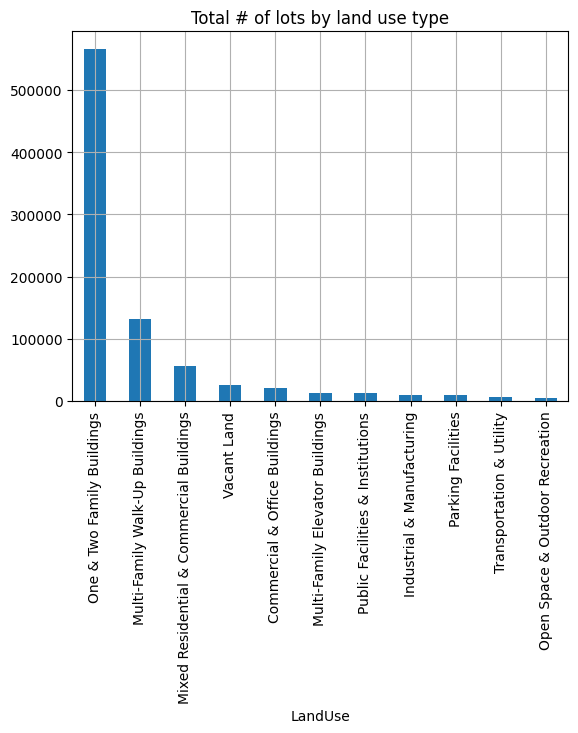

In [11]:
pluto_ogrio["LandUse"].value_counts().plot.bar()
plt.grid()
plt.title("Total # of lots by land use type")

Text(0.5, 1.0, 'Total lot area by land use type')

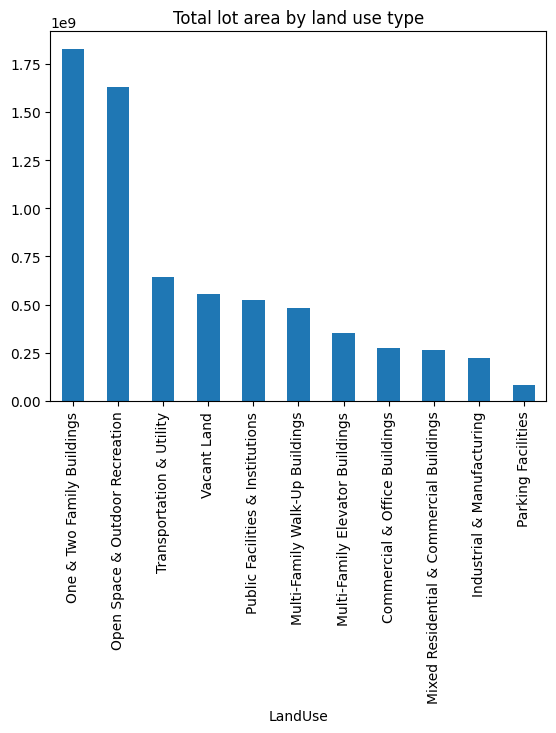

In [12]:
pluto_ogrio.groupby("LandUse").LotArea.sum().sort_values(ascending=False).plot.bar()
plt.title("Total lot area by land use type")

Text(0.5, 1.0, 'Total building area by land use type')

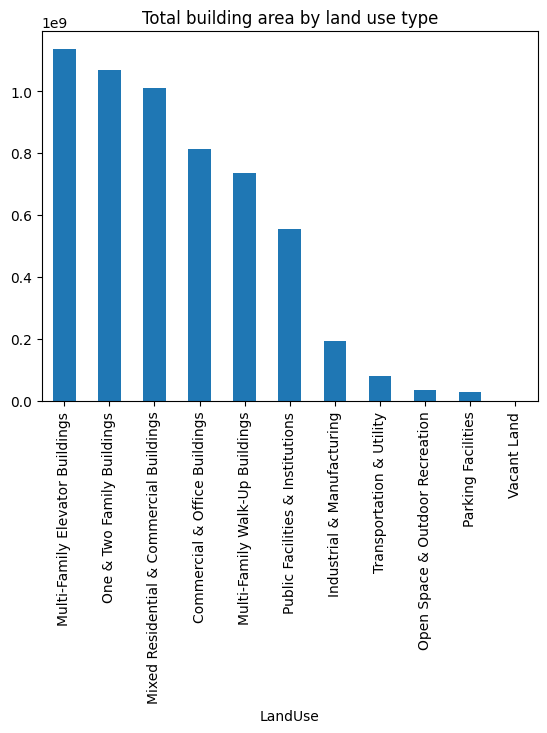

In [13]:
# now the same but for building area
pluto_ogrio.groupby("LandUse").BldgArea.sum().sort_values(ascending=False).plot.bar()
plt.title("Total building area by land use type")

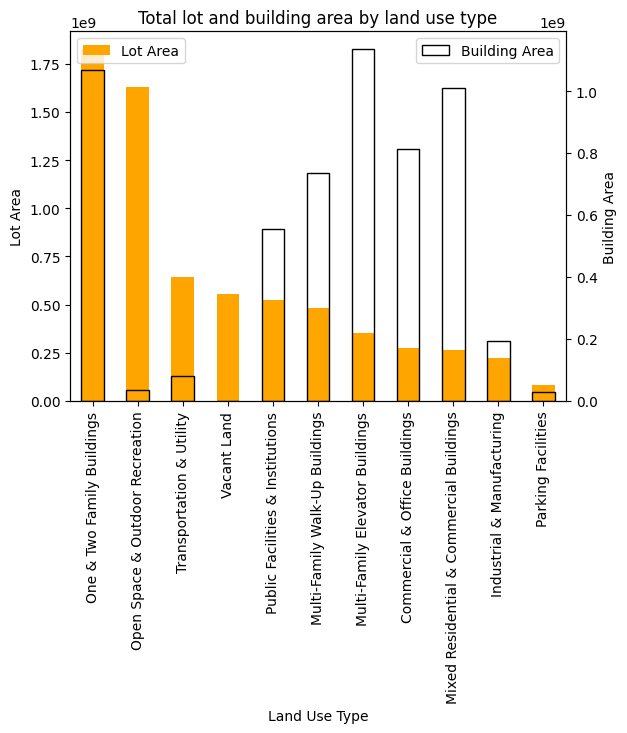

In [14]:
# plot both lot and building area on the same plot with a secondary y-axis
fig, ax = plt.subplots()
by_lot_area = pluto_ogrio.groupby("LandUse").LotArea.sum().sort_values(ascending=False)

by_lot_area.plot.bar(ax=ax, color="orange")

# get order to apply below
order = {v: i for i, v in enumerate(by_lot_area.index)}

ax.set_ylabel("Lot Area")
ax.set_xlabel("Land Use Type")

ax2 = ax.twinx()
pluto_ogrio.groupby("LandUse").BldgArea.sum().reindex(by_lot_area.index).plot.bar(
    ax=ax2, edgecolor="black", color="none"
)
ax2.set_ylabel("Building Area")

plt.title("Total lot and building area by land use type")

# add legends
ax.legend(["Lot Area"], loc="upper left")
ax2.legend(["Building Area"], loc="upper right")

## numeric column


In [15]:
pluto_ogrio["NumFloors"].describe()

count    856819.000000
mean          2.357554
std           2.012707
min           0.000000
25%           2.000000
50%           2.000000
75%           2.500000
max         104.000000
Name: NumFloors, dtype: float64

<Axes: ylabel='Frequency'>

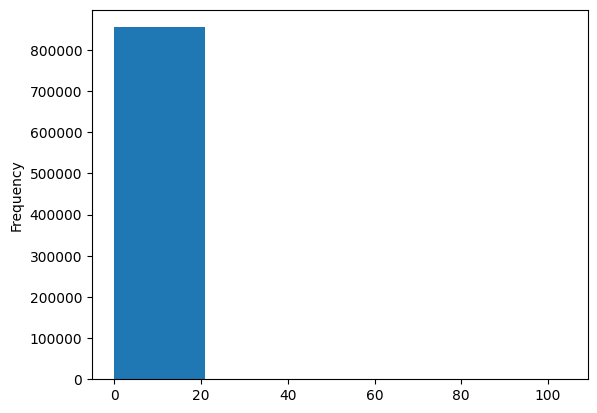

In [16]:
pluto_ogrio["NumFloors"].plot.hist(bins=5)

<Axes: title={'center': 'NumFloors'}, xlabel='Borough'>

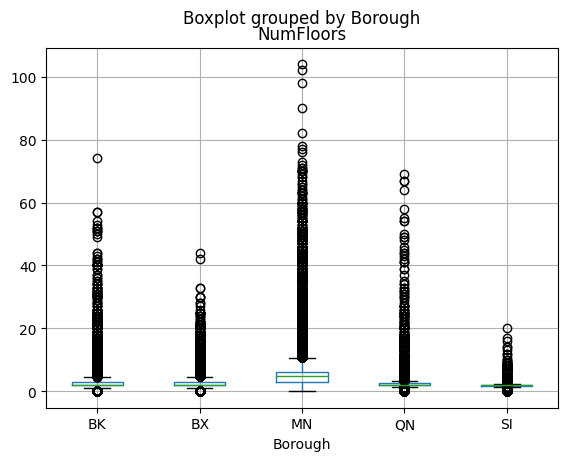

In [17]:
pluto_ogrio.boxplot(column="NumFloors", by="Borough")

<Axes: ylabel='Frequency'>

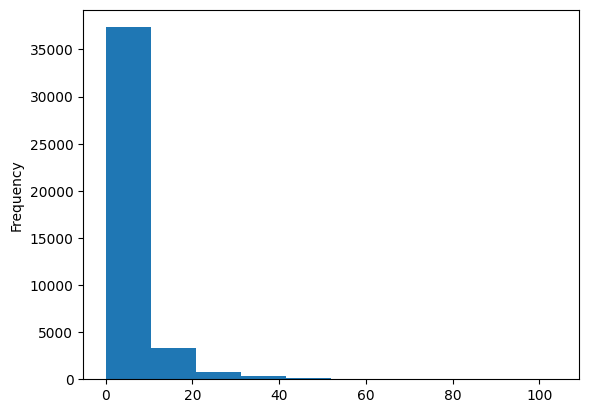

In [18]:
pluto_ogrio[pluto_ogrio.Borough.eq("MN")]["NumFloors"].plot.hist(bins=10)

In [19]:
# get clusters using kmeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(pluto_ogrio[["NumFloors"]])

pluto_ogrio["NumFloorsCluster"] = kmeans.predict(pluto_ogrio[["NumFloors"]])

In [20]:
pluto_ogrio.groupby("NumFloorsCluster").NumFloors.describe().sort_values("max")

,count,mean,std,min,25%,50%,75%,max
NumFloorsCluster,,,,,,,,
0,567252.0,1.698166,0.585285,0.00,1.67,2.0,2.0,2.30
3,247338.0,2.943488,0.452372,2.33,2.50,3.0,3.0,4.33
2,36595.0,5.880553,1.241193,4.50,5.00,6.0,6.0,11.00
1,4726.0,16.344901,4.169347,11.50,13.00,15.0,19.0,28.00
4,908.0,39.898128,10.368211,29.00,32.00,37.0,44.0,104.00


<Axes: xlabel='NumFloors', ylabel='BldgArea'>

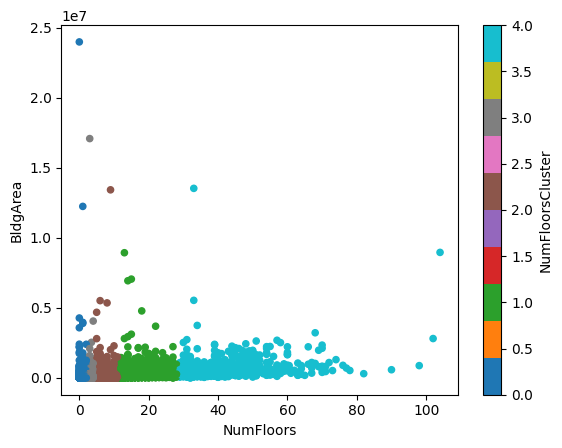

In [21]:
pluto_ogrio.plot.scatter(
    x="NumFloors", y="BldgArea", c="NumFloorsCluster", cmap="tab10"
)

<Axes: ylabel='Frequency'>

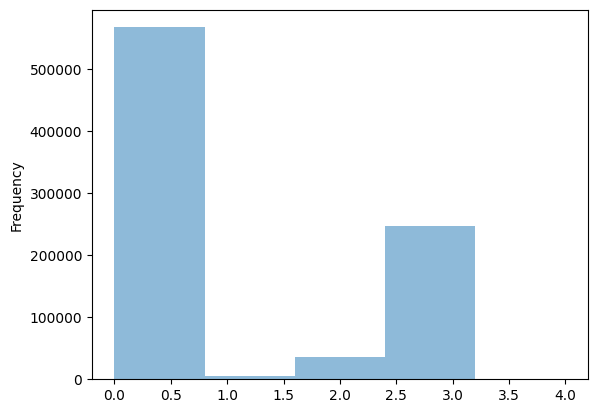

In [22]:
pluto_ogrio["NumFloorsCluster"].plot.hist(bins=5, alpha=0.5)

# and now, mapping


Text(0.5, 1.0, 'NYC MapPLUTO')

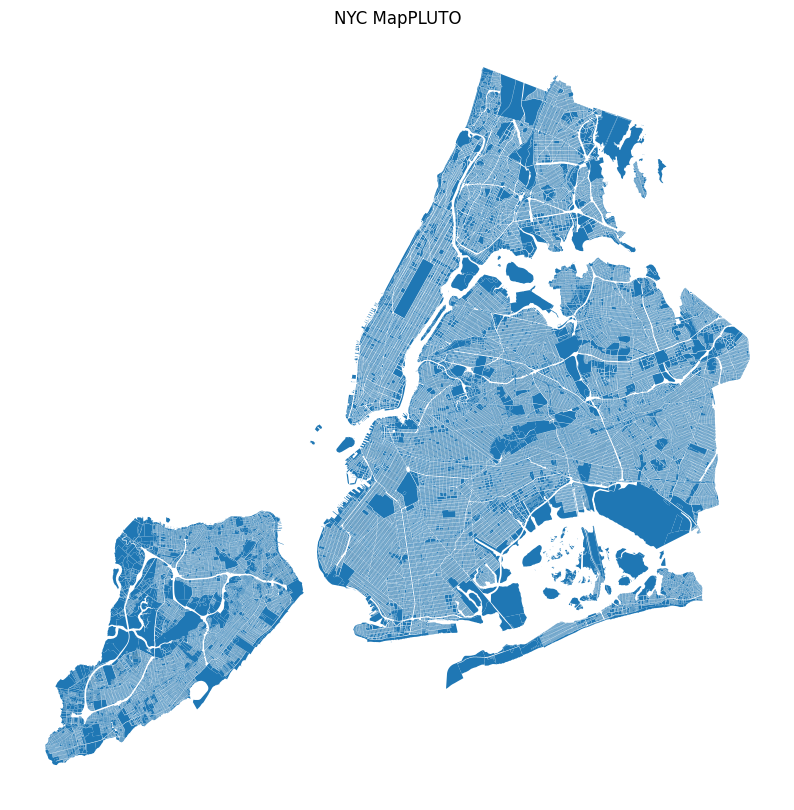

In [23]:
pluto_ogrio.plot(figsize=(10, 10)).set_axis_off()
plt.title("NYC MapPLUTO")

In [24]:
pluto_ogrio_wgs = pluto_ogrio.to_crs("epsg:4326")

In [29]:
layer = PolygonLayer.from_geopandas(pluto_ogrio_wgs[["LandUse", "geometry"]])
m = Map(layer)
m

Map(layers=[PolygonLayer(table=pyarrow.Table
LandUse: string
geometry: list<item: list<item: list<item: fixed_…